## Portfolio simulation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class import PortfolioSimulation

In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})

In [3]:
# LLM recommendations
llm_recommendations = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)
# llm_recommendations2 = pd.read_csv("../data/ciks2_ratings.csv", dtype={"cik": str})
# llm_recommendations2.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
# llm_recommendations3 = pd.read_csv("../data/ciks3_ratings.csv", dtype={"cik": str})
# llm_recommendations3.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
# llm_recommendations4 = pd.read_csv("../data/ciks4_ratings.csv", dtype={"cik": str})
# llm_recommendations4.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
# llm_recommendations5 = pd.read_csv("../data/ciks5_ratings.csv", dtype={"cik": str})
# llm_recommendations5.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
# llm_recommendations6 = pd.read_csv("../data/ciks6_ratings.csv", dtype={"cik": str})
# llm_recommendations6.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  

# # Concat all llm recommendations into one DataFrame
# llm_recommendations = pd.concat([
#     llm_recommendations1, llm_recommendations2, llm_recommendations3,
#     llm_recommendations4, llm_recommendations5, llm_recommendations6
# ], ignore_index=True)

In [4]:
import re

def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

- Subsetting CIK date combinations that are present in LLM recommendations as well as sell-side analyst ratings

In [5]:
# Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M")
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M")
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

In [6]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
# Merge to find common CIK and date combinations
all_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [7]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)

In [8]:
len(all_ciks_and_dates), len(llm_recommendations_final), len(analyst_ratings_final)

(8119, 8119, 8119)

---
### Selected stock test simulation 

In [9]:
# Subset 1 CIK for testing
cik = "0001996862"
cik_prices = stock_prices[stock_prices["cik"] == cik]
cik_llm_recommendations = llm_recommendations_final[llm_recommendations_final["cik"] == cik]
cik_llm_recommendations.rename(columns={"extracted_rating": "action"}, inplace=True)
cik_analyst_ratings = analyst_ratings[analyst_ratings["cik"] == cik]
# Drop nas from analyst ratings
cik_analyst_ratings = cik_analyst_ratings.dropna(subset=["rating"])
# Keep only 

C:\Users\benny\AppData\Local\Temp\ipykernel_23872\1687351846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cik_llm_recommendations.rename(columns={"extracted_rating": "action"}, inplace=True)


In [10]:
type(cik_llm_recommendations["date"].iloc[0])

str

In [11]:
start_capital = 100000
cik_sim = PortfolioSimulation(initial_capital = start_capital)
cik_sim.load_stock_prices(cik_prices)
cik_sim.load_recommendations(cik_llm_recommendations)

# Run simulation
cik_sim.simulate_trading()

Simulating Trades: 100%|██████████| 90/90 [00:00<00:00, 929.58it/s]


In [12]:
cik_prices

,date,cik,price,security
20818,2001-08,0001996862,18.25,Bunge Global
20819,2001-09,0001996862,17.00,Bunge Global
20820,2001-10,0001996862,17.62,Bunge Global
20821,2001-11,0001996862,19.35,Bunge Global
20822,2001-12,0001996862,23.28,Bunge Global
...,...,...,...,...
21094,2024-08,0001996862,101.38,Bunge Global
21095,2024-09,0001996862,96.64,Bunge Global
21096,2024-10,0001996862,84.02,Bunge Global
21097,2024-11,0001996862,89.74,Bunge Global


In [13]:
cik_sim.portfolio_statistics()

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 813.68it/s]


{'Mean return (monthly)': np.float64(1e-06),
 'Geometric mean return (monthly)': np.float64(1e-06),
 'Standard deviation (monthly)': np.float64(6e-06),
 'Annualized mean return': np.float64(7e-06),
 'Annualized standard deviation': np.float64(2.2e-05),
 'Number of transactions': 5,
 'Skipped transactions': 0}

In [14]:
cik_returns = cik_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 267/267 [00:00<00:00, 943.37it/s]


Text(0.5, 0, 'Date')

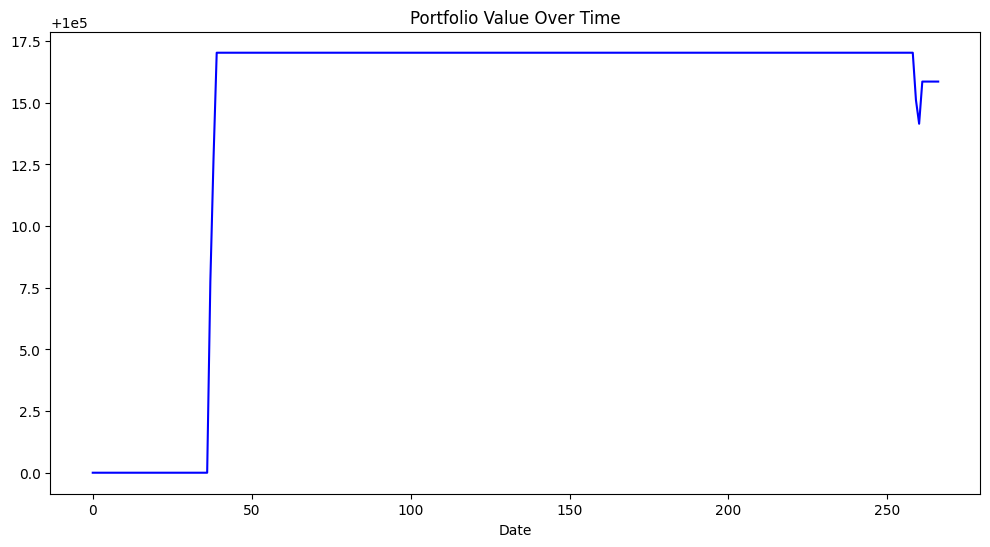

In [15]:
# plot start value over time
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(cik_returns.index, cik_returns['start_value'], label='PF at start of month', color='blue')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')

---

### LLM recommendations simulation

In [16]:
# Initialize portfolio simulation
llm_sim = PortfolioSimulation(initial_capital=start_capital)

# Load data
llm_sim.load_stock_prices(stock_prices)
llm_sim.load_recommendations(llm_recommendations_final)

# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 8119/8119 [02:33<00:00, 52.90it/s]


In [17]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [03:42<00:00,  1.38it/s]


In [18]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.000857),
 'Geometric mean return (monthly)': np.float64(0.000824),
 'Standard deviation (monthly)': np.float64(0.008093),
 'Annualized mean return': np.float64(0.010329),
 'Annualized standard deviation': np.float64(0.028034),
 'Number of transactions': 1289,
 'Skipped transactions': 140}

Text(0.5, 0, 'Date')

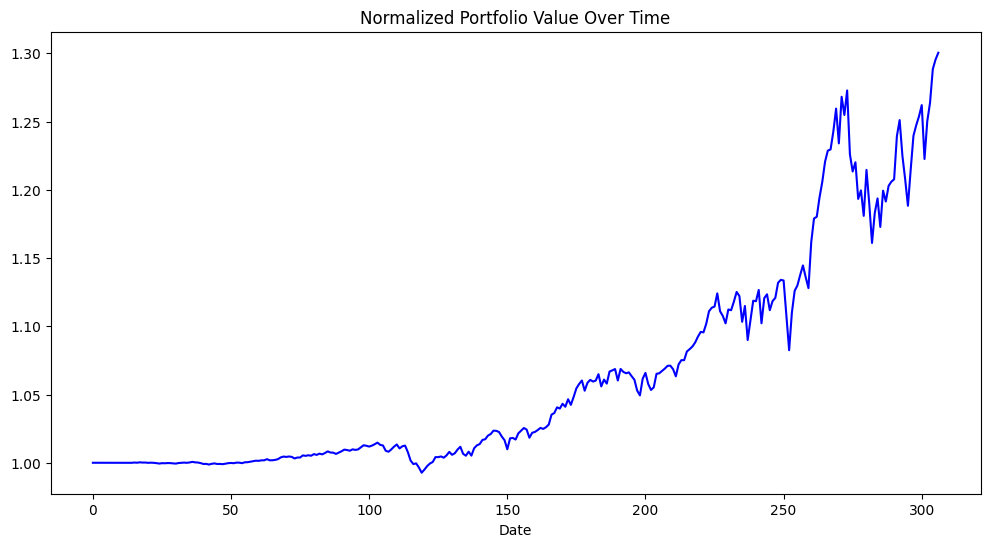

In [19]:
# plot start value over time
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(llm_returns.index, llm_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')

In [20]:
llm_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 297/297 [01:48<00:00,  2.75it/s]


,cik,quantity,total_value
date,,,
2000-02,cash,99962,99962.875000
2000-02,0001341439,1,37.125000
2000-03,cash,99877,99877.858482
2000-03,0001341439,1,39.031250
2000-03,0000912728,1,15.791651
...,...,...,...
2024-10,0001230245,2,561.268534
2024-10,0000730272,4,537.080000
2024-10,0001297184,2,101.060000


In [21]:
llm_sim.no_transactions

1289

---
### Analyst recommendations simulation

In [74]:
analyst_sim = PortfolioSimulation(initial_capital=start_capital)
analyst_sim.load_stock_prices(stock_prices)
analyst_sim.load_recommendations(analyst_ratings_final)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 8119/8119 [01:51<00:00, 73.05it/s]


In [75]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [04:09<00:00,  1.23it/s]


In [76]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.003036),
 'Geometric mean return (monthly)': np.float64(0.002659),
 'Standard deviation (monthly)': np.float64(0.027495),
 'Annualized mean return': np.float64(0.037048),
 'Annualized standard deviation': np.float64(0.095244)}

Text(0.5, 0, 'Date')

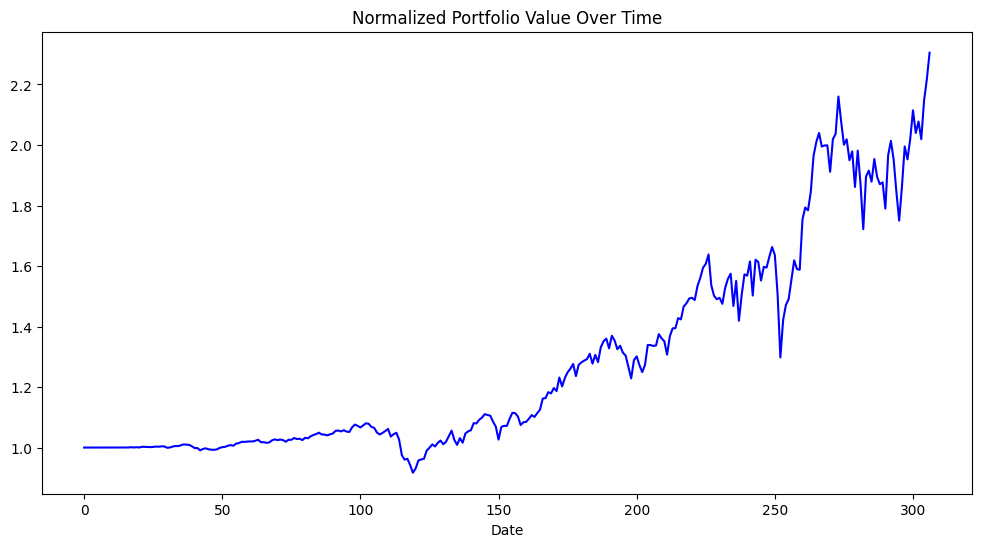

In [77]:
# plot start value over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(analyst_returns.index, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')

In [80]:
analyst_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 264/264 [01:50<00:00,  2.40it/s]


,cik,quantity,total_value
date,,,
2000-01,cash,99885,99885.421875
2000-01,0000048465,1,5.078125
2000-01,0000064803,1,17.468750
2000-01,0000084748,1,19.000000
2000-01,0000088941,1,30.000000
...,...,...,...
2024-09,0000106640,53,5671.000000
2024-09,0000108312,62,10633.620000
2024-09,0000200406,73,11830.380000


In [82]:
max_date = analyst_ratings_final["date"].max()
max_date

'2024-10'

In [83]:
analyst_sim.get_portfolio_value(max_date)

np.float64(225963.878)

In [84]:
analyst_returns

,month,start_value,end_value,return,normalized_start_value,normalized_end_value
0,1999-04,100000.000,100000.000,0.000000,1.000000,1.000000
1,1999-05,100000.000,100000.000,0.000000,1.000000,1.000000
2,1999-06,100000.000,100000.000,0.000000,1.000000,1.000000
3,1999-07,100000.000,100000.000,0.000000,1.000000,1.000000
4,1999-08,100000.000,100000.000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...
302,2024-06,207761.953,201933.463,-0.028054,2.077620,2.019335
303,2024-07,201933.463,214606.863,0.062760,2.019335,2.146069
304,2024-08,214606.863,221669.113,0.032908,2.146069,2.216691
305,2024-09,221669.113,230501.843,0.039846,2.216691,2.305018


In [ ]:
1.002659**307

2.2596945107025324

In [88]:
analyst_sim.no_transactions

1983